In [1]:
import pandas as pd
import keras
import numpy as np
import os
from tqdm import tqdm
from time import time
from sklearn.metrics import roc_curve,roc_auc_score,f1_score,accuracy_score,precision_recall_curve,auc
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split,KFold
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from collections import Counter,defaultdict
from PIL import Image,ImageOps
import glob 
import cv2
import pickle
try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 1.x
except Exception:
  pass

TensorFlow is already loaded. Please restart the runtime to change versions.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


PIPELINE

1. Load in the pickle files which contain images (DONE)
2. Load in the CSVs for train/test/val (DONE)
3. Create the output labels (the One Hot Encoded versions) (DONE)

4. Rescale into [0,1] range
5. Model the problem

  a. 3 input tensors

  b. DENSENET/MOBILENET layer

  c. Flatten layer

  d. LSTM Layer

  e. Sigmoid Layer


6. Plot the Loss/Accuracy plots
7. Plot the ROC plots per class (investigate the F1 score also)

# **Load images and get the outputs: X,y creation**

In [2]:
!ls

sample_data


In [5]:
os.chdir("/content/drive/Shared drives/ECS 289G Deep Learning Project/Project/Datasets/")
!pwd

/content/drive/Shared drives/ECS 289G Deep Learning Project/Project/Datasets


In [6]:
!ls

 bin_files			        images_pickled
'csv files'			        images_zip_files
 Data_Entry_2017_v2020.gsheet	       'Process NIH Dataset Details.ipynb'
'Filter and Create Sample Sets.ipynb'  'Sample Set Images.ipynb'
 images


In [7]:
classes = ['No Finding','Infiltration',
           'Effusion','Atelectasis','Nodule', 'Mass',
           'Pleural_Thickening','Fibrosis','Pneumothorax',
           'Cardiomegaly','Consolidation','Emphysema',
           'Pneumonia','Hernia','Edema']

mapper = dict(zip(classes, range(0,len(classes))))
mapper

{'Atelectasis': 3,
 'Cardiomegaly': 9,
 'Consolidation': 10,
 'Edema': 14,
 'Effusion': 2,
 'Emphysema': 11,
 'Fibrosis': 7,
 'Hernia': 13,
 'Infiltration': 1,
 'Mass': 5,
 'No Finding': 0,
 'Nodule': 4,
 'Pleural_Thickening': 6,
 'Pneumonia': 12,
 'Pneumothorax': 8}

In [8]:
def one_hot_encode(y,num_classes= 15):
  num_samples = len(y)
  y_final = np.zeros((num_samples,num_classes))
  for i,label in enumerate(y):
    y_final[i][mapper[label]] = 1
  
  return y_final

## **PA**

### **Train X,y**

In [9]:
with open("images_pickled/all_PA_files/PA_images.pkl",'rb') as f:
  PA_imgs = pickle.load(f)

len(PA_imgs)

12151

In [10]:
train_pa = pd.read_csv("/content/drive/Shareddrives/ECS 289G Deep Learning Project/Project/Datasets/csv files/with_sampling_index_csv/PA_train.csv")
train_pa

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Sample #,full_path
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143000,0.143000,1,images/images1/00000001_000.png
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143000,0.143000,1,images/images1/00000001_001.png
2,00000001_002.png,Effusion,2,1,58,M,PA,2500,2048,0.168000,0.168000,1,images/images1/00000001_002.png
3,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143000,0.143000,2,images/images1/00000001_000.png
4,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143000,0.143000,2,images/images1/00000001_001.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17521,00030068_002.png,Effusion,2,30068,59,F,PA,1841,2020,0.194311,0.194311,8109,images/images12/00030068_002.png
17522,00030068_003.png,Atelectasis,3,30068,60,F,PA,2021,2021,0.194311,0.194311,8109,images/images12/00030068_003.png
17523,00030068_001.png,No Finding,1,30068,59,F,PA,1827,2021,0.194311,0.194311,8111,images/images12/00030068_001.png
17524,00030068_002.png,Effusion,2,30068,59,F,PA,1841,2020,0.194311,0.194311,8111,images/images12/00030068_002.png


In [11]:
#TRAIN SET X Creation
all_train_samples = train_pa.groupby(by = 'Sample #',axis = 0)
X_train_1st = []
X_train_2nd = []
X_train_3rd = []
y_train = []
for sample_num,sample_df in all_train_samples:
  label = sample_df["Finding Labels"].values[-1]
  image_vectors = sample_df['Image Index'].map(lambda x: PA_imgs[x]).values
  X_train_1st.append(image_vectors[0])
  X_train_2nd.append(image_vectors[1])
  X_train_3rd.append(image_vectors[2])
  y_train.append(label)

In [12]:
np.array(X_train_1st).shape

(5842, 128, 128)

In [13]:
np.array(X_train_2nd).shape

(5842, 128, 128)

In [14]:
np.array(X_train_3rd).shape

(5842, 128, 128)

In [15]:
np.array(y_train).shape

(5842,)

In [16]:
y_train_ohe = one_hot_encode(y_train)

In [17]:
print(y_train_ohe.shape)
y_train_ohe[:10]

(5842, 15)


array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [18]:
y_train[:10]

['Effusion',
 'Cardiomegaly',
 'Hernia',
 'Infiltration',
 'Hernia',
 'Hernia',
 'Hernia',
 'Hernia',
 'Nodule',
 'Infiltration']

### **Test X,y**

In [19]:
test_pa = pd.read_csv("/content/drive/Shareddrives/ECS 289G Deep Learning Project/Project/Datasets/csv files/with_sampling_index_csv/PA_test.csv")
test_pa

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Sample #,full_path
0,00000003_003.png,Hernia|Infiltration,3,3,76,F,PA,2698,2991,0.143000,0.143000,7,images/images1/00000003_003.png
1,00000003_004.png,Hernia,4,3,77,F,PA,2500,2048,0.168000,0.168000,7,images/images1/00000003_004.png
2,00000003_005.png,Hernia,5,3,78,F,PA,2686,2991,0.143000,0.143000,7,images/images1/00000003_005.png
3,00000103_005.png,Mass|Pneumothorax,5,103,60,M,PA,2992,2991,0.143000,0.143000,38,images/images1/00000103_005.png
4,00000103_006.png,Pneumothorax,6,103,60,M,PA,2992,2991,0.143000,0.143000,38,images/images1/00000103_006.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4864,00030068_002.png,Effusion,2,30068,59,F,PA,1841,2020,0.194311,0.194311,8110,images/images12/00030068_002.png
4865,00030068_003.png,Infiltration,3,30068,60,F,PA,2021,2021,0.194311,0.194311,8110,images/images12/00030068_003.png
4866,00030434_000.png,Atelectasis,0,30434,53,M,PA,2021,2021,0.194308,0.194308,8114,images/images12/00030434_000.png
4867,00030434_001.png,Atelectasis,1,30434,53,M,PA,2021,2021,0.194311,0.194311,8114,images/images12/00030434_001.png


In [20]:
#TEST SET X Creation
all_test_samples = test_pa.groupby(by = 'Sample #',axis = 0)
X_test_1st = []
X_test_2nd = []
X_test_3rd = []
y_test = []
for sample_num,sample_df in all_test_samples:
  label = sample_df["Finding Labels"].values[-1]
  image_vectors = sample_df['Image Index'].map(lambda x: PA_imgs[x]).values
  X_test_1st.append(image_vectors[0])
  X_test_2nd.append(image_vectors[1])
  X_test_3rd.append(image_vectors[2])
  y_test.append(label)

In [21]:
np.array(X_test_1st).shape

(1623, 128, 128)

In [22]:
np.array(X_test_2nd).shape

(1623, 128, 128)

In [23]:
np.array(X_test_3rd).shape

(1623, 128, 128)

In [24]:
np.array(y_test).shape

(1623,)

In [25]:
y_test_ohe = one_hot_encode(y_test)

In [26]:
print(y_test_ohe.shape)
y_test_ohe[:10]

(1623, 15)


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [27]:
y_test[:10]

['Hernia',
 'Mass',
 'Mass',
 'Mass',
 'Effusion',
 'Atelectasis',
 'Pleural_Thickening',
 'Effusion',
 'No Finding',
 'No Finding']

### **Val X,y**

In [28]:
val_pa = pd.read_csv("/content/drive/Shareddrives/ECS 289G Deep Learning Project/Project/Datasets/csv files/with_sampling_index_csv/PA_val.csv")
val_pa

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Sample #,full_path
0,00000020_000.png,Pleural_Thickening,0,20,53,M,PA,2978,2991,0.143000,0.143000,12,images/images1/00000020_000.png
1,00000020_001.png,Fibrosis|Infiltration,1,20,47,M,PA,2992,2991,0.143000,0.143000,12,images/images1/00000020_001.png
2,00000020_002.png,Fibrosis,2,20,48,M,PA,2414,2991,0.143000,0.143000,12,images/images1/00000020_002.png
3,00000054_001.png,No Finding,1,54,72,F,PA,2544,3056,0.139000,0.139000,17,images/images1/00000054_001.png
4,00000054_002.png,No Finding,2,54,74,F,PA,2021,2021,0.194311,0.194311,17,images/images1/00000054_002.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1942,00030350_001.png,No Finding,1,30350,24,M,PA,2021,2021,0.194311,0.194311,8112,images/images12/00030350_001.png
1943,00030350_002.png,No Finding,2,30350,25,M,PA,2021,2021,0.194311,0.194311,8112,images/images12/00030350_002.png
1944,00030427_000.png,No Finding,0,30427,70,M,PA,2021,2021,0.194311,0.194311,8113,images/images12/00030427_000.png
1945,00030427_001.png,No Finding,1,30427,70,M,PA,2021,2021,0.194311,0.194311,8113,images/images12/00030427_001.png


In [29]:
#VAL SET X Creation
all_val_samples = val_pa.groupby(by = 'Sample #',axis = 0)
X_val_1st = []
X_val_2nd = []
X_val_3rd = []
y_val = []
for sample_num,sample_df in all_val_samples:
  label = sample_df["Finding Labels"].values[-1]
  image_vectors = sample_df['Image Index'].map(lambda x: PA_imgs[x]).values
  X_val_1st.append(image_vectors[0])
  X_val_2nd.append(image_vectors[1])
  X_val_3rd.append(image_vectors[2])
  y_val.append(label)

In [30]:
np.array(X_val_1st).shape

(649, 128, 128)

In [31]:
np.array(X_val_2nd).shape

(649, 128, 128)

In [32]:
np.array(X_val_3rd).shape

(649, 128, 128)

In [33]:
np.array(y_val).shape

(649,)

In [34]:
y_val_ohe = one_hot_encode(y_val)

In [35]:
print(y_val_ohe.shape)
y_val_ohe[:10]

(649, 15)


array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [36]:
y_val[:10]

['Fibrosis',
 'No Finding',
 'No Finding',
 'Pneumothorax',
 'Effusion',
 'Pleural_Thickening',
 'Effusion',
 'No Finding',
 'No Finding',
 'No Finding']

## **AP**

### **Train X,y**

In [ ]:
with open("images_pickled/all_AP_files/AP_images.pkl",'rb') as f:
  AP_imgs = pickle.load(f)

len(AP_imgs)

3768

In [ ]:
train_ap = pd.read_csv("/content/drive/Shareddrives/ECS 289G Deep Learning Project/Project/Datasets/csv files/with_sampling_index_csv/AP_train.csv")
train_ap

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Sample #,full_path
0,00000032_000.png,Cardiomegaly,0,32,55,F,AP,2500,2048,0.168,0.168,1,images/images1/00000032_000.png
1,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,55,F,AP,2500,2048,0.168,0.168,1,images/images1/00000032_001.png
2,00000032_002.png,No Finding,2,32,55,F,AP,2500,2048,0.168,0.168,1,images/images1/00000032_002.png
3,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,55,F,AP,2500,2048,0.168,0.168,2,images/images1/00000032_001.png
4,00000032_002.png,No Finding,2,32,55,F,AP,2500,2048,0.168,0.168,2,images/images1/00000032_002.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8431,00030770_001.png,Infiltration,1,30770,23,F,AP,3056,2544,0.139,0.139,3904,images/images12/00030770_001.png
8432,00030770_002.png,No Finding,2,30770,23,F,AP,3056,2544,0.139,0.139,3904,images/images12/00030770_002.png
8433,00030772_000.png,No Finding,0,30772,26,F,AP,3056,2544,0.139,0.139,3905,images/images12/00030772_000.png
8434,00030772_001.png,Consolidation,1,30772,26,F,AP,3056,2544,0.139,0.139,3905,images/images12/00030772_001.png


In [ ]:
#TRAIN SET X Creation
all_train_samples = train_ap.groupby(by = 'Sample #',axis = 0)
X_train_1st = []
X_train_2nd = []
X_train_3rd = []
y_train = []
for sample_num,sample_df in all_train_samples:
  label = sample_df["Finding Labels"].values[-1]
  image_vectors = sample_df['Image Index'].map(lambda x: AP_imgs[x]).values
  X_train_1st.append(image_vectors[0])
  X_train_2nd.append(image_vectors[1])
  X_train_3rd.append(image_vectors[2])
  y_train.append(label)

In [ ]:
np.array(X_train_1st).shape

(2812, 128, 128)

In [ ]:
np.array(X_train_2nd).shape

(2812, 128, 128)

In [ ]:
np.array(X_train_3rd).shape

(2812, 128, 128)

In [ ]:
np.array(y_train).shape

(2812,)

In [ ]:
y_train_ohe = one_hot_encode(y_train)

In [ ]:
print(y_train_ohe.shape)
y_train_ohe[:10]

(2812, 15)


array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
y_train[:10]

['No Finding',
 'No Finding',
 'Edema',
 'Effusion',
 'Cardiomegaly',
 'No Finding',
 'Atelectasis',
 'Effusion',
 'Edema',
 'Effusion']

### **Test X,y**

In [ ]:
test_ap = pd.read_csv("/content/drive/Shareddrives/ECS 289G Deep Learning Project/Project/Datasets/csv files/with_sampling_index_csv/AP_test.csv")
test_ap

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Sample #,full_path
0,00000032_004.png,Cardiomegaly|Edema|Effusion,4,32,55,F,AP,2500,2048,0.168,0.168,8,images/images1/00000032_004.png
1,00000032_005.png,No Finding,5,32,55,F,AP,2500,2048,0.168,0.168,8,images/images1/00000032_005.png
2,00000032_006.png,Infiltration,6,32,55,F,AP,2500,2048,0.168,0.168,8,images/images1/00000032_006.png
3,00000032_007.png,Cardiomegaly|Edema|Effusion,7,32,55,F,AP,2500,2048,0.168,0.168,14,images/images1/00000032_007.png
4,00000032_008.png,No Finding,8,32,55,F,AP,2500,2048,0.168,0.168,14,images/images1/00000032_008.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2338,00030609_021.png,Atelectasis|Infiltration,21,30609,6,M,AP,3056,2544,0.139,0.139,3887,images/images12/00030609_021.png
2339,00030609_022.png,Infiltration,22,30609,6,M,AP,3056,2544,0.139,0.139,3887,images/images12/00030609_022.png
2340,00030733_001.png,No Finding,1,30733,26,F,AP,3056,2544,0.139,0.139,3900,images/images12/00030733_001.png
2341,00030733_002.png,Consolidation,2,30733,26,F,AP,2544,3056,0.139,0.139,3900,images/images12/00030733_002.png


In [ ]:
#TEST SET X Creation
all_test_samples = test_ap.groupby(by = 'Sample #',axis = 0)
X_test_1st = []
X_test_2nd = []
X_test_3rd = []
y_test = []
for sample_num,sample_df in all_test_samples:
  label = sample_df["Finding Labels"].values[-1]
  image_vectors = sample_df['Image Index'].map(lambda x: AP_imgs[x]).values
  X_test_1st.append(image_vectors[0])
  X_test_2nd.append(image_vectors[1])
  X_test_3rd.append(image_vectors[2])
  y_test.append(label)

In [ ]:
np.array(X_test_1st).shape

(781, 128, 128)

In [ ]:
np.array(X_test_2nd).shape

(781, 128, 128)

In [ ]:
np.array(X_test_3rd).shape

(781, 128, 128)

In [ ]:
np.array(y_test).shape

(781,)

In [ ]:
y_test_ohe = one_hot_encode(y_test)

In [ ]:
print(y_test_ohe.shape)
y_test_ohe[:10]

(781, 15)


array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
y_test[:10]

['Infiltration',
 'No Finding',
 'Consolidation',
 'No Finding',
 'Infiltration',
 'Cardiomegaly',
 'Cardiomegaly',
 'Effusion',
 'Infiltration',
 'Effusion']

### **Val X,y**

In [ ]:
val_ap = pd.read_csv("/content/drive/Shareddrives/ECS 289G Deep Learning Project/Project/Datasets/csv files/with_sampling_index_csv/AP_val.csv")
val_ap

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Sample #,full_path
0,00000032_005.png,No Finding,5,32,55,F,AP,2500,2048,0.168,0.168,12,images/images1/00000032_005.png
1,00000032_006.png,Atelectasis|Effusion|Infiltration,6,32,55,F,AP,2500,2048,0.168,0.168,12,images/images1/00000032_006.png
2,00000032_007.png,Cardiomegaly,7,32,55,F,AP,2500,2048,0.168,0.168,12,images/images1/00000032_007.png
3,00000032_010.png,No Finding,10,32,55,F,AP,2500,2048,0.168,0.168,17,images/images1/00000032_010.png
4,00000032_011.png,Infiltration,11,32,55,F,AP,2500,2048,0.168,0.168,17,images/images1/00000032_011.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...
931,00030609_003.png,No Finding,3,30609,6,M,AP,3056,2544,0.139,0.139,3864,images/images12/00030609_003.png
932,00030609_004.png,No Finding,4,30609,6,M,AP,2544,3056,0.139,0.139,3864,images/images12/00030609_004.png
933,00030733_004.png,No Finding,4,30733,26,F,AP,3056,2544,0.139,0.139,3903,images/images12/00030733_004.png
934,00030733_005.png,No Finding,5,30733,26,F,AP,3056,2544,0.139,0.139,3903,images/images12/00030733_005.png


In [ ]:
#VAL SET X Creation
all_val_samples = val_ap.groupby(by = 'Sample #',axis = 0)
X_val_1st = []
X_val_2nd = []
X_val_3rd = []
y_val = []
for sample_num,sample_df in all_val_samples:
  label = sample_df["Finding Labels"].values[-1]
  image_vectors = sample_df['Image Index'].map(lambda x: AP_imgs[x]).values
  X_val_1st.append(image_vectors[0])
  X_val_2nd.append(image_vectors[1])
  X_val_3rd.append(image_vectors[2])
  y_val.append(label)

In [ ]:
np.array(X_val_1st).shape

(312, 128, 128)

In [ ]:
np.array(X_val_2nd).shape

(312, 128, 128)

In [ ]:
np.array(X_val_3rd).shape

(312, 128, 128)

In [ ]:
np.array(y_val).shape

(312,)

In [ ]:
y_val_ohe = one_hot_encode(y_val)

In [ ]:
print(y_val_ohe.shape)
y_val_ohe[:10]

(312, 15)


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
y_val[:10]

['Cardiomegaly',
 'Atelectasis',
 'Consolidation',
 'Cardiomegaly',
 'Edema',
 'Effusion',
 'Infiltration',
 'Consolidation',
 'Edema',
 'No Finding']

# **MODELLING**

Architecture in common

1. Inputs: 1st, 2nd, 3rd followups; (128 by 128 for each sample)
2. Output: 15 dimension vector
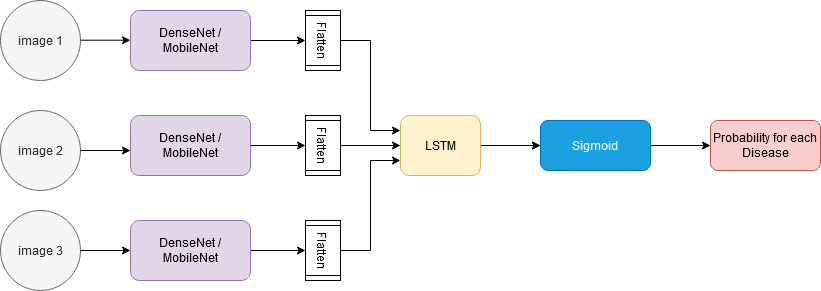



In [37]:
def plot_roc_curve(figsize=(10,10), n_class=15, class_names=[], y_test=[],y_score=[]):
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
  TPR,FPR = [],[]
  roc_auc = np.zeros(n_class)
  plt.figure(figsize=figsize)
  for i in range(n_class):
    fpr,tpr,thresholds = roc_curve(y_test[:,i],y_score[:,i])
    FPR.append(fpr)
    TPR.append(tpr)
    roc_auc[i] = auc(fpr,tpr)    
    pred = y_score[:,i] >= 0.5
    f1 = f1_score(y_test[:,i],pred)
    plt.plot(fpr,tpr,label=f"class: {class_names[i]}, auc: {roc_auc[i]}, f1 = {f1:.2f}")
  
  plt.plot([0,1],[0,1],linestyle='--')
  plt.xlim([0.0,1.0])
  plt.xlabel('FPR')
  plt.ylim([0.0,1.0])
  plt.ylabel('TPR')
  plt.title('ROC Curves')
  plt.legend()
  plt.show()


In [38]:
IMAGE_SIZE = (128,128)

In [39]:
NUM_EPOCHS = 10

In [40]:
X_train_1st = np.array(X_train_1st) / 255.0
X_train_2nd = np.array(X_train_2nd) /255.0
X_train_3rd = np.array(X_train_3rd) /255.0

X_val_1st = (np.array(X_val_1st) /255.0)
X_val_2nd = (np.array(X_val_2nd) /255.0)
X_val_3rd = (np.array(X_val_3rd) /255.0)

In [41]:
X_train_1st = X_train_1st.reshape((X_train_1st.shape[0],X_train_1st.shape[1],X_train_1st.shape[2],1))
X_train_2nd = X_train_2nd.reshape((X_train_2nd.shape[0],X_train_2nd.shape[1],X_train_2nd.shape[2],1))
X_train_3rd = X_train_3rd.reshape((X_train_3rd.shape[0],X_train_3rd.shape[1],X_train_3rd.shape[2],1))

X_val_1st = X_val_1st.reshape((X_val_1st.shape[0],X_val_1st.shape[1],X_val_1st.shape[2],1))
X_val_2nd = X_val_2nd.reshape((X_val_2nd.shape[0],X_val_2nd.shape[1],X_val_2nd.shape[2],1))
X_val_3rd =X_val_3rd.reshape((X_val_3rd.shape[0],X_val_3rd.shape[1],X_val_3rd.shape[2],1))

In [42]:
X_test_1st = (np.array(X_test_1st) /255.0)
X_test_2nd = (np.array(X_test_2nd) /255.0)
X_test_3rd = (np.array(X_test_3rd) /255.0)

X_test_1st = X_test_1st.reshape((X_test_1st.shape[0],X_test_1st.shape[1],X_test_1st.shape[2],1))
X_test_2nd = X_test_2nd.reshape((X_test_2nd.shape[0],X_test_2nd.shape[1],X_test_2nd.shape[2],1))
X_test_3rd =X_test_3rd.reshape((X_test_3rd.shape[0],X_test_3rd.shape[1],X_test_3rd.shape[2],1))

## **MobileNETV2**

Reference: https://stackoverflow.com/questions/60582442/multiple-image-input-for-keras-application

### **With LSTM**

In [66]:
input1 = keras.Input(shape = (IMAGE_SIZE[0],IMAGE_SIZE[1],1))
input2 = keras.Input(shape = (IMAGE_SIZE[0],IMAGE_SIZE[1],1))
input3 = keras.Input(shape = (IMAGE_SIZE[0],IMAGE_SIZE[1],1))

#Use MobileNetV2 for feature extraction
feature_extract = keras.applications.MobileNetV2(include_top=False,weights=None,input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],1))
feature_extract.trainable = False

#get the CNN based output for each of the 3 images followups
cnn_out1 = feature_extract(input1)
cnn_out2 = feature_extract(input2)
cnn_out3 = feature_extract(input3)

#flatten each of the outputs
cout1 = keras.layers.Flatten()(cnn_out1)
cout2 = keras.layers.Flatten()(cnn_out2)
cout3 = keras.layers.Flatten()(cnn_out3)

concatted = keras.layers.Concatenate(axis=-1)([cout1, cout2, cout3]) #merge all the three 

reshaped = keras.layers.Reshape((-1,concatted.shape[1]))(concatted) #reshape the value by adding a third dimension
lstm = keras.layers.LSTM(50,activation='tanh',recurrent_activation='sigmoid')(reshaped) #LSTM layer
dropout = keras.layers.Dropout(0.2)(lstm) #Dropouts added
output_layer = keras.layers.Dense(15,activation='sigmoid')(dropout) #output layer for prediction
model = keras.models.Model(inputs= [input1,input2,input3],outputs = output_layer)
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
mobilenetv2_1.00_128 (Functiona (None, 4, 4, 1280)   2257408     input_5[0][0]                    
                                                                 input_6[0][0]         

In [67]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss='binary_crossentropy', metrics = keras.metrics.BinaryAccuracy())

In [68]:
model.fit([X_train_1st,X_train_2nd,X_train_3rd],y=y_train_ohe,epochs=NUM_EPOCHS,batch_size=100,validation_data= ([X_val_1st,X_val_2nd,X_val_3rd],y_val_ohe))

Epoch 1/10
59/59 [==============================] - 207s 4s/step - loss: 0.3413 - binary_accuracy: 0.9367 - val_loss: 0.1767 - val_binary_accuracy: 0.9357
Epoch 2/10
59/59 [==============================] - 205s 3s/step - loss: 0.1730 - binary_accuracy: 0.9364 - val_loss: 0.1726 - val_binary_accuracy: 0.9357
Epoch 3/10
59/59 [==============================] - 205s 3s/step - loss: 0.1724 - binary_accuracy: 0.9364 - val_loss: 0.1723 - val_binary_accuracy: 0.9357
Epoch 4/10
59/59 [==============================] - 205s 3s/step - loss: 0.1722 - binary_accuracy: 0.9369 - val_loss: 0.1727 - val_binary_accuracy: 0.9357
Epoch 5/10
59/59 [==============================] - 202s 3s/step - loss: 0.1724 - binary_accuracy: 0.9370 - val_loss: 0.1725 - val_binary_accuracy: 0.9357
Epoch 6/10
59/59 [==============================] - 201s 3s/step - loss: 0.1724 - binary_accuracy: 0.9367 - val_loss: 0.1725 - val_binary_accuracy: 0.9333
Epoch 7/10
59/59 [==============================] - 202s 3s/step - los

In [69]:
print(model)
history = model.history.history #use this for plotting loss and accuracy
history

{'binary_accuracy': [0.9367339015007019,
  0.9364488124847412,
  0.9363802075386047,
  0.9369396567344666,
  0.9370079636573792,
  0.9366996884346008,
  0.9367569088935852,
  0.9367114305496216,
  0.9370306730270386,
  0.9368483424186707],
 'loss': [0.34133610129356384,
  0.17302857339382172,
  0.17236313223838806,
  0.17222106456756592,
  0.17236696183681488,
  0.172372967004776,
  0.1722944974899292,
  0.1724088340997696,
  0.1720721274614334,
  0.17229150235652924],
 'val_binary_accuracy': [0.9356959462165833,
  0.9356959462165833,
  0.9356959462165833,
  0.9356959462165833,
  0.9356959462165833,
  0.9333332180976868,
  0.9356959462165833,
  0.9356959462165833,
  0.9356959462165833,
  0.9356959462165833],
 'val_loss': [0.17665615677833557,
  0.1726221740245819,
  0.17234808206558228,
  0.17266474664211273,
  0.17252647876739502,
  0.17254796624183655,
  0.17248013615608215,
  0.17263168096542358,
  0.1726708561182022,
  0.17262333631515503]}

In [70]:
scores = model.evaluate([X_test_1st,X_test_2nd,X_test_3rd],y_test_ohe) #test accuracy and loss plots
scores

51/51 [==============================] - 50s 985ms/step - loss: 0.1678 - binary_accuracy: 0.9395


[0.16780278086662292, 0.9395358562469482]

Text(0.5, 1.0, 'Accuracy vs epochs')

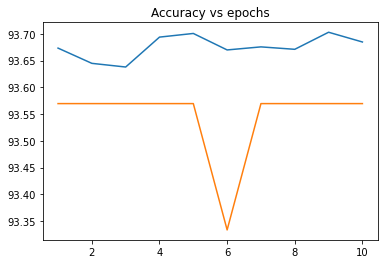

In [71]:
epochs = range(1,NUM_EPOCHS + 1)
plt.plot(epochs,np.array(history['binary_accuracy'])*100.00,label = 'train')
plt.plot(epochs,np.array(history['val_binary_accuracy'])*100.00,label = 'validation')
plt.title("Accuracy vs epochs")

In [72]:
y_pred = model.predict([X_test_1st,X_test_2nd,X_test_3rd])

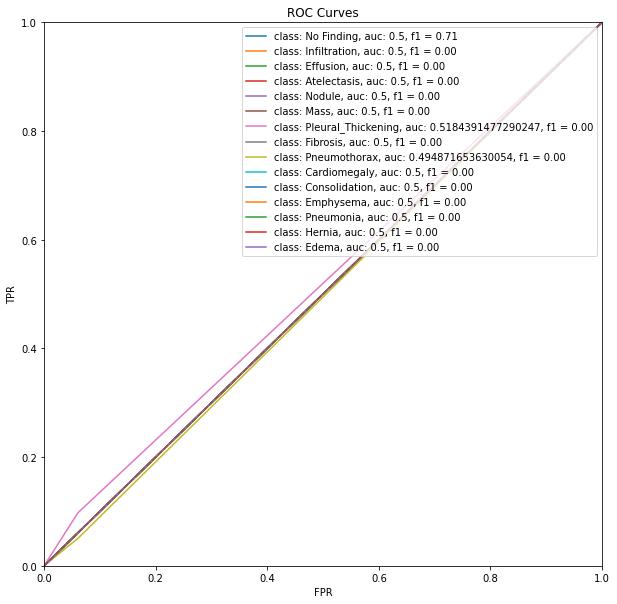

In [73]:
plot_roc_curve(figsize=(10,10),y_test=y_test_ohe,y_score=y_pred,class_names=list(mapper.keys()))

In [74]:
# serialize model to YAML
model_yaml = model.to_yaml()
with open("/content/drive/Shareddrives/ECS 289G Deep Learning Project/Project/Datasets/YAML/MobileNetV2_LSTM_PA.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
# serialize weights to HDF5
model.save_weights("/content/drive/Shareddrives/ECS 289G Deep Learning Project/Project/Datasets/YAML/MobileNetV2_LSTM_PA.h5")
print("Saved model to disk")

Saved model to disk


### **Without LSTM**

In [75]:
input1 = keras.Input(shape = (IMAGE_SIZE[0],IMAGE_SIZE[1],1))
input2 = keras.Input(shape = (IMAGE_SIZE[0],IMAGE_SIZE[1],1))
input3 = keras.Input(shape = (IMAGE_SIZE[0],IMAGE_SIZE[1],1))

#Use DenseNET 169 for feature extraction
feature_extract = keras.applications.MobileNetV2(include_top=False,weights=None,input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],1))
feature_extract.trainable = False

#get the CNN based output for each of the 3 images followups
cnn_out1 = feature_extract(input1)
cnn_out2 = feature_extract(input2)
cnn_out3 = feature_extract(input3)

#flatten each of the outputs
cout1 = keras.layers.Flatten()(cnn_out1)
cout2 = keras.layers.Flatten()(cnn_out2)
cout3 = keras.layers.Flatten()(cnn_out3)

concatted = keras.layers.Concatenate(axis=-1)([cout1, cout2, cout3]) #merge all the three 


dropout = keras.layers.Dropout(0.2)(concatted) #Dropouts added
output_layer = keras.layers.Dense(15,activation='sigmoid')(dropout) #output layer for prediction
model = keras.models.Model(inputs= [input1,input2,input3],outputs = output_layer)
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
mobilenetv2_1.00_128 (Functiona (None, 4, 4, 1280)   2257408     input_9[0][0]                    
                                                                 input_10[0][0]        

In [76]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss='binary_crossentropy', metrics = keras.metrics.BinaryAccuracy())

In [77]:
model.fit([X_train_1st,X_train_2nd,X_train_3rd],y=y_train_ohe,epochs=NUM_EPOCHS,batch_size=100,validation_data= ([X_val_1st,X_val_2nd,X_val_3rd],y_val_ohe))

Epoch 1/10
59/59 [==============================] - 199s 3s/step - loss: 0.5836 - binary_accuracy: 0.9372 - val_loss: 0.4855 - val_binary_accuracy: 0.9357
Epoch 2/10
59/59 [==============================] - 197s 3s/step - loss: 0.4199 - binary_accuracy: 0.9374 - val_loss: 0.3641 - val_binary_accuracy: 0.9357
Epoch 3/10
59/59 [==============================] - 196s 3s/step - loss: 0.3263 - binary_accuracy: 0.9374 - val_loss: 0.2951 - val_binary_accuracy: 0.9357
Epoch 4/10
59/59 [==============================] - 198s 3s/step - loss: 0.2724 - binary_accuracy: 0.9374 - val_loss: 0.2545 - val_binary_accuracy: 0.9357
Epoch 5/10
59/59 [==============================] - 197s 3s/step - loss: 0.2400 - binary_accuracy: 0.9374 - val_loss: 0.2295 - val_binary_accuracy: 0.9357
Epoch 6/10
59/59 [==============================] - 197s 3s/step - loss: 0.2198 - binary_accuracy: 0.9374 - val_loss: 0.2135 - val_binary_accuracy: 0.9357
Epoch 7/10
59/59 [==============================] - 198s 3s/step - los

In [78]:
history = model.history.history #use this for plotting loss and accuracy
history

{'binary_accuracy': [0.9372360706329346,
  0.9373504519462585,
  0.937350332736969,
  0.9373503923416138,
  0.9373505711555481,
  0.9373503923416138,
  0.9373501539230347,
  0.9373503923416138,
  0.937350332736969,
  0.9373502135276794],
 'loss': [0.5835666060447693,
  0.41990235447883606,
  0.3263184130191803,
  0.27237623929977417,
  0.24003395438194275,
  0.21977591514587402,
  0.2065444141626358,
  0.19759570062160492,
  0.19134552776813507,
  0.1868872046470642],
 'val_binary_accuracy': [0.9356959462165833,
  0.9356959462165833,
  0.9356959462165833,
  0.9356959462165833,
  0.9356959462165833,
  0.9356959462165833,
  0.9356959462165833,
  0.9356959462165833,
  0.9356959462165833,
  0.9356959462165833],
 'val_loss': [0.485477477312088,
  0.3641333281993866,
  0.29508572816848755,
  0.25445473194122314,
  0.22952836751937866,
  0.21350979804992676,
  0.20285356044769287,
  0.19544918835163116,
  0.19023223221302032,
  0.18637236952781677]}

In [79]:
scores = model.evaluate([X_test_1st,X_test_2nd,X_test_3rd],y_test_ohe) #test accuracy and loss plots
scores

51/51 [==============================] - 49s 965ms/step - loss: 0.1819 - binary_accuracy: 0.9395


[0.18194279074668884, 0.9395358562469482]

Text(0.5, 1.0, 'Accuracy vs epochs')

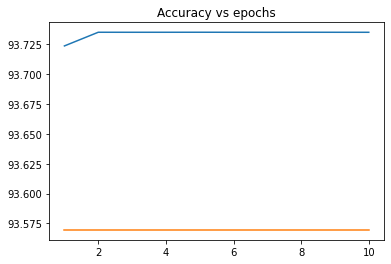

In [80]:
epochs = range(1,NUM_EPOCHS+1)
plt.plot(epochs,np.array(history['binary_accuracy'])*100.00,label = 'train')
plt.plot(epochs,np.array(history['val_binary_accuracy'])*100.00,label = 'validation')
plt.title("Accuracy vs epochs")

In [81]:
y_pred = model.predict([X_test_1st,X_test_2nd,X_test_3rd])

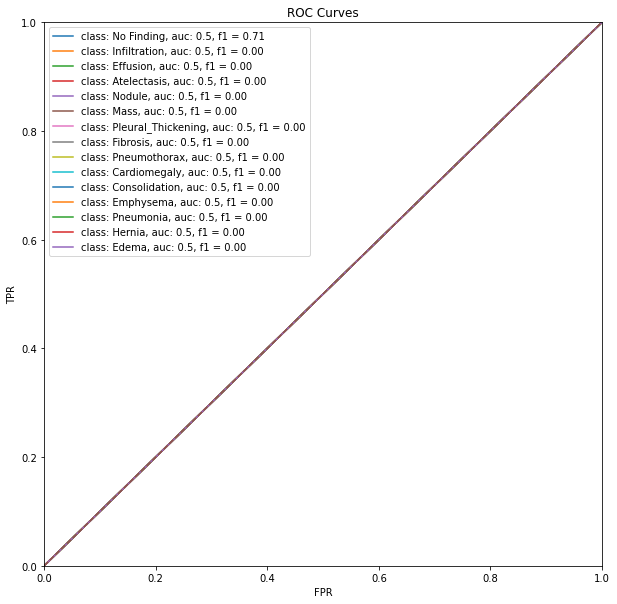

In [82]:
plot_roc_curve(figsize=(10,10),y_test=y_test_ohe,y_score=y_pred,class_names=list(mapper.keys()))

In [83]:
# serialize model to YAML
model_yaml = model.to_yaml()
with open("/content/drive/Shareddrives/ECS 289G Deep Learning Project/Project/Datasets/YAML/MobileNetV2_PA.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
# serialize weights to HDF5
model.save_weights("/content/drive/Shareddrives/ECS 289G Deep Learning Project/Project/Datasets/YAML/MobileNetV2_PA.h5")
print("Saved model to disk")

Saved model to disk
